In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


In [3]:
# global variables
FOLDER_PREFIX="resnet_test_gpu_worker"

worker_num_interval = [2, 4, 8, 16, 32, 64]
# single node means, we have single worker node in cluster (ps+worker0)
single_node_time=765.886
# signle machine means we only consider training on local machine, thus there is no communication cost
single_machine_time=697.278

In [20]:
global_dict_saver = []
for num_w in worker_num_interval:
    # master is also include in this one, so the first worker should be the master
    time_stats_dict = {}
    for worker_index in range(num_w):
        if worker_index == 0:
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_master', 'rb')
        else:
            # for the case of 8 workers, we only consider master, worker0,...,worker6
            out_file=open(FOLDER_PREFIX+str(num_w)+'/out_worker_'+str(worker_index-1), 'rb')
        for line in out_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('INFO:tensorflow:Worker(.*): (.*): step (.*), loss = (.*).* examples/sec; (.*) sec/batch.*', line_string)
            if search_sth:
                worker_index, cur_step, worker_time_cost = int(search_sth.group(1)), int(search_sth.group(3)), float(search_sth.group(5))
                if cur_step <= 300:
                    #print(worker_index, cur_step, worker_time_cost)
                    if cur_step not in time_stats_dict.keys():
                        time_stats_dict[cur_step]=[worker_time_cost]
                    else:
                        time_stats_dict[cur_step].append(worker_time_cost)
    global_dict_saver.append(time_stats_dict)

normal_speedup_vals = [1.0,]
ideal_speedup_vals = [1.0,]
normal_speedup_vals_local = [1.0,]
ideal_speedup_vals_local = [1.0,]
for dict_idx, stat_dict in enumerate(global_dict_saver):
    counter_list = [0]*worker_num_interval[dict_idx]
    range_tmp = [i+1 for i in range(worker_num_interval[dict_idx])]
    for k, v in stat_dict.iteritems():
        sorted_v = sorted(v)
        for c_i, _ in enumerate(counter_list):
            counter_list[c_i] += sorted_v[c_i]
    normal_speedup_vals.append(float(single_node_time)/counter_list[-1])
    ideal_speedup_vals.append(float(single_node_time)/counter_list[0])
    normal_speedup_vals_local.append(float(single_machine_time)/counter_list[-1])
    ideal_speedup_vals_local.append(float(single_machine_time)/counter_list[0])
    print("Cluster set up with {} workers: ideal time: {} full time:{}".format(worker_num_interval[dict_idx], counter_list[0], counter_list[-1]))

Cluster set up with 2 workers: ideal time: 327.102 full time:354.651
Cluster set up with 4 workers: ideal time: 162.22 full time:207.481
Cluster set up with 8 workers: ideal time: 85.242 full time:116.557
Cluster set up with 16 workers: ideal time: 66.177 full time:91.508
Cluster set up with 32 workers: ideal time: 69.562 full time:143.078
Cluster set up with 64 workers: ideal time: 189.168 full time:267.081


In [21]:
print(normal_speedup_vals)
print
print(ideal_speedup_vals)
print
print(normal_speedup_vals_local)
print
print(ideal_speedup_vals_local)
workers_interval=[1, 2, 4, 8, 16, 32, 64]

[1.0, 2.1595484011041832, 3.6913548710484343, 6.570913801830848, 8.36960702889366, 5.352926375822972, 2.8676169401791967]

[1.0, 2.3414286675104403, 4.7212797435581315, 8.984843152436596, 11.573295858077591, 11.010120468071651, 4.0487080267275655]

[1.0, 1.9660962467327028, 3.360683628862403, 5.9822919258388465, 7.619858373038433, 4.873411705503287, 2.610736068833051]

[1.0, 2.1316836949942224, 4.298347922574282, 8.179981699162388, 10.536561040845017, 10.023834852361924, 3.6860251205277854]


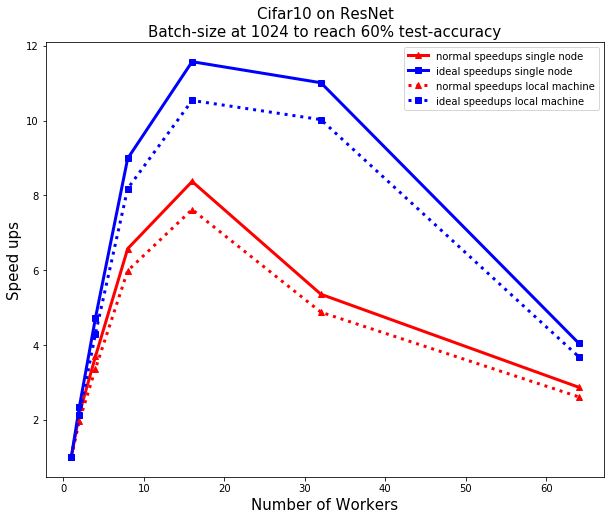

In [22]:
fig=plt.figure(1)
plt.plot(workers_interval, normal_speedup_vals, '-^r', linewidth=3.0, label="normal speedups single node")
plt.plot(workers_interval, ideal_speedup_vals, '-sb', linewidth=3.0, label='ideal speedups single node')
plt.plot(workers_interval, normal_speedup_vals_local, ':^r', linewidth=3.0, label="normal speedups local machine")
plt.plot(workers_interval, ideal_speedup_vals_local, ':sb', linewidth=3.0, label='ideal speedups local machine')
plt.title("Cifar10 on ResNet\nBatch-size at 1024 to reach 60% test-accuracy", multialignment='center',
         fontsize=15)
plt.xlabel("Number of Workers", fontsize=15)
plt.ylabel("Speed ups", fontsize=15)
plt.legend()
plt.savefig("straggler_ideal_speedup_comparison_GPU.jpg", dpi=600)
plt.show()